# Functional Programming with Pyomo

Pyomo, an abbreviation for **Py**thon **O**ptimization **M**odeling **O**bjects, might not appear to be a suitable choice for functional programming. Functional programming, after all, relies on pure, stateless functions that operate on immutable data. Pyomo's workflow, instead, is based mutating a model's state using transformations and solvers. These approaches would seem to be fundamentally incompatible at first glance.

The objective of this notebook is to demonstrate how encapsulating Pyomo transformations and solvers within relatively pure functions, along with a simple **PyomoMonad**, can create a functional programming environment for optimization that supports a flexible and expressive optimization workflows.



## Pyomo and Optimization Workflows

A typical Pyomo workflow begins with a problem statement and then proceeds through a series of steps that, coupled with inputs of data, model transformations, and solvers, results in a solution. 

![](../../media/pyomo-workflow.drawio.png)


1. A mathematical model is created from a problem statement and model of the available data.

2. A Python code is prepared that can read relevant data and generates an instance of a Pyomo ConcreteModel.

3. Optional transformations may be applied to convert the model into a solvable form.

4. A solver is selected and applied to compute a solution and load into the model object.

5. A suitable solution report is extracted from the solved model object.

Given the range of possible problem types, modeling choices, transformations, and solvers, this can be complex workflow with opportunities for generating exceptions, and the need to log and display intermediate results.

This notebook implements the Pyomo workflow by applying abstractions from functional programming and category theory. A simple **PyomoMonad** is proposed to enable the utilization of pure functions at each stage, from model construction to the presentation of the optimal solution.

## Functional Programming and Monads

This section provides a brief and generic introduction to functional programming and monads. Readers familiar with these topics can skip forward to the section where these concepts are applied to the Pyomo workflow.

### Pure functions

A characteristic feature of functional programming is the use of "pure" functions. Pure functions always returns the same result for identical arguments with no side effects such as changing non-local variables or call-by-reference arguments, printing, or data base interactions. Because there are no side effects, there is no change in state between invocations of a pure function. All results of calling a pure function are restricted to the result returned by the function.

There are important practical advantages for pure function that result from from these restrictions. For example, pure functions are generally short with a single purpose, they can be executed concurrency because there is no common state, are easily tested, and allow recursion. These advantages make pure functions useful building blocks for complex applications.


Python lambda functions are examples of pure functions. Here we create a series of three lambda functions:

* `trim` that strips white space from a string, 
* `upper` that converts a string to upper case,
* `exclaim` that appends an exclamation symbol.


In [1]:
# pure functions
trim = lambda s : s.strip()
upper = lambda s : s.upper()
exclaim = lambda s : s + "!"

These can be nested in various combinations and applied to a string.

In [2]:
exclaim(upper(trim(" get off my lawn")))

'GET OFF MY LAWN!'

### Function composition

A composition of these functions is useful for combining the effects of these functions. Given two functions, $f$ and $g$,

$$
\begin{align}
f : A & \rightarrow B \\
g : B & \rightarrow C \\
\end{align}
$$

the composition of $f$ and $g$ is defined as

$$
\begin{align}
g \circ f: A & \rightarrow C \\
\end{align}
$$

where

$$\text{compose(f, g)(x)} = (g\circ f) (x) = g(f(x))$$

In [3]:
# function composition
compose = lambda f, g : lambda x : g(f(x))

To demonstrate, a new function `enthuse` is created from the composition of `trim`, `upper` and `exclaim`.

In [4]:
enthuse = compose(compose(trim, upper), exclaim)
enthuse(" get off my lawn")

'GET OFF MY LAWN!'

Composition is associative. Given three functions

$$
\begin{align}
f : A & \rightarrow B \\
g : B & \rightarrow C \\
h : C & \rightarrow D \\
\end{align}
$$

then 

$$h\circ g\circ f = (h\circ g)\circ f = h\circ (g\circ f)$$

In [5]:
print(compose(compose(trim, upper), exclaim)(" get off my lawn"))
print(compose(trim, compose(upper, exclaim))(" get off my lawn"))

GET OFF MY LAWN!
GET OFF MY LAWN!


### `map`, `filter`, and `functools.reduce`

The functions `map`, `filter`, and `functools.reduce` extend the utility of pure functions. Note that `map` actually returns an iterator, so `list` is required to apply the function to every element of the data given in `map`.

In [6]:
list(map(enthuse, ["hello", "go away", " get off my lawn"]))

['HELLO!', 'GO AWAY!', 'GET OFF MY LAWN!']

`reduce` applies a function of two values recursively to a tuple, list, or iterator to reduce it to a single cumulative value. This provides a convenient means to construct of composition of two or more functions.

In [7]:
from functools import reduce

enthuse = reduce(compose, (trim, upper, exclaim))
enthuse(" get off my lawn")

'GET OFF MY LAWN!'

### Why monads? 

Composing pure functions is a highly expressive and flexible style of programming, but consider what happens when something happens that causes a change of state. In the following cell, for example, an exception is generated when a composite function is applied to an input with the wrong type.

In [8]:
# this will produce an error message
try:
    enthuse(2)
except Exception as e:
    print(e)

'int' object has no attribute 'strip'


This may not be a desirable result for a more complex workflow. This is where monads fit in.

A monad wraps the inputs and outputs of a pure function into a structure that can perform additional computation. There two basic methods for monads:

* **unit** which wraps a value into a monad.
* **bind** which chains pure functions together.

### The **Maybe** monad

 The following cell shows a Python implementation for a **Maybe** monad. The **Maybe** monad wraps a value the may contain a value. If the result of bind produces an error, the value stored is `None` and a flag is set.

In [9]:
class Maybe:
    def __init__(self, value=None, contains_value=True):
        self.value = value
        self.contains_value = contains_value

    def bind(self, func):
        if not self.contains_value:
            return Maybe(None, False)

        try:
            result = func(self.value)
            return Maybe(result)

        except:
            return Maybe(None, False)

    def __call__(self):
        return self.value

To see how this works, let's create an instance of **Maybe** and bind the composite function `enthuse`.

In [10]:
Maybe(" get off my lawn").bind(enthuse)()

'GET OFF MY LAWN!'

The important thing to notice is that the pure functions previously defined can be applied and composed with no changes. All of the boilerplate code need to check for errors has been encapsulated in the **Maybe** monad.

In [11]:
Maybe(" get off my lawn").bind(trim).bind(upper).bind(exclaim)()

'GET OFF MY LAWN!'

Why do this? One benefit of **Maybe** is that we now have a way to avoid or capture error messages produced when from a composition of functions.

In [12]:
# this will not generate an error
Maybe(2).bind(enthuse)()

### The Failure monad

The **Failure** monad is designed to handle exceptions. Without modifying any of the previously defined functions, **Failure** captures the first exception and pushes it to the end of a chain of calculations. All of the boilerplate is in the monad, not the functions.

In [13]:
class Failure:

    def __init__(self, value=None, status=None):
        self.value = value
        self.status = status

    def bind(self, f):
        if self.status is not None:
            return Failure(None, self.status)

        try:
            result = f(self.value)
            return Failure(result, None)

        except Exception as e:
            return Failure(None, e)

    def __call__(self):
        return self.value

In [14]:
Failure(" get off my lawn").bind(enthuse)()

'GET OFF MY LAWN!'

In [15]:
Failure(2).bind(enthuse).status

AttributeError("'int' object has no attribute 'strip'")

## A Pyomo monad


In brief, a monad is a structure that wraps a value inside an object so that it can be passed through a series of functions. 


The functions are assumed to be stateless and without side effect. In other words, given the same input the functions will always the same output. The purpose of the monad is handle situations where a function results in

for restricting access to a value. The reasons for restricting access are specific to the application. For Pyomo models, for example, 

* spe that are specific to the scenario. In Pyomo, for example, we ca

This first implementation of a Pyomo monad comprises three elements:

* Wrapping Pyomo solvers and transformers as functions. The solvers and transfers clone the model to avoid changes in the state of the model that is passed by reference.

* A **PyomoMonad** with a unit and bind functions. The monad will "lift" the Pyomo model by adding attributes for status and an effect. The effect is what will executed when the monad is executed.

* Pyomo models are created by model builders that take problem data and produce a Pyomo model encapsulated in a **PyomoMonad**. The monad can include an optional effect. The effect should produce any desired side effects, such as plots or reports written to files, and return any desired output from the model. The effect is called by call the monad.

### Import Pyomo and solvers

In [16]:
# for use on Google Colab
import sys
if "google.colab" in sys.modules:
    !pip install -q idaes-pse
    !idaes get-extensions

### Wrapping Pyomo solvers and transformations as "pure" functions

Create some "pure" functions for processing Pyomo models. These are 

In [17]:
# given a string specification, returns a solver created by pyomo.SolverFactory
def solver(s=None):
    if s is None:
        _solver = lambda model : model.clone()
    else:
        def _solver(model):
            new_model = model.clone()
            pyo.SolverFactory(s).solve(new_model)
            return new_model
    return _solver

In [18]:
# given a string specification, returns a transformer created by pyomo.TransformationFactory
def transformer(s=None):
    if s is None:
        _transformer = lambda model : model.clone()
    else:
        def _transformer(model):
            new_model = model.clone()
            pyo.TransformationFactory(s).apply_to(new_model)
            return new_model
    return _transformer

### **PyomoMonad**

The an implementation of a simple Pyomo monad. The monad can bind a functions that operates on a model object. A bound function must return a model object. Errors are captured and added to the status. An effect can be specified that will be the returned by the monad when called as a function. The ">>" operator is overridden to provide a little syntax sugar for representing workflows.

In [19]:
class PyomoMonad:
    """A simple monad class for handling Pyomo operations with error handling.
    
    This class is designed to simplify Pyomo operations by providing a way to
    handle errors and chaining operations together. The bind method is used to
    chain operations, and the __call__ method is used to execute the monad.
    """

    def __init__(self, value=None, effect=None, status=None):
        """
        Initialize the PyomoMonad instance.
        
        :param value: The value to be processed by the monad
        :type value: Any
        :param effect: A function to be applied on the value
        :type effect: callable, optional
        :param status: The current status of the monad, used for error handling
        :type status: Any, optional
        """
        self.value = value
        self.status = status
        self.effect = effect

    def bind(self, func):
        """Bind a function to the current monad instance.
        
        :param func: The function to be bound to the current monad
        :type func: callable
        :return: A new PyomoMonad instance
        :rtype: PyomoMonad
        """
        if self.status is not None:
            return PyomoMonad(None, self.effect, self.status)

        try:
            result = func(self.value)
            return PyomoMonad(result, self.effect, self.status)

        except Exception as e:
            return PyomoMonad(None, lambda value: print(self.status), status=e)

    def __call__(self):
        """Execute the monad by calling its effect if it exists, or return its value.
        
        :return: The result of executing the monad's effect or its value
        :rtype: Any
        """
        if self.effect is not None:
            return self.effect(self.value)
        else:
            return self.value

    def __rshift__(self, func):
        """Implement the '>>' operator for chaining operations.
        
        :param func: The function to be bound to the current monad
        :type func: callable
        :return: A new PyomoMonad instance
        :rtype: PyomoMonad
        """
        return self.bind(func)


## Example: Production Planning

In [20]:
products = {
    "U": {"price": 270, "demand": 40},
    "V": {"price": 210, "demand": None},
}

resources = {
    "M": {"price": 10, "available": None},
    "labor A": {"price": 50, "available": 100},
    "labor B": {"price": 40, "available":  80},
}

processes = {
    "U": {"M": 10, "labor A": 2, "labor B": 1},
    "V": {"M":  9, "labor A": 1, "labor B": 1},
}

In [21]:
import pyomo.environ as pyo
import pandas as pd
from functools import reduce

def production_model(products, resources, processes):

    m = pyo.ConcreteModel()

    m.PRODUCTS = pyo.Set(initialize=list(products.keys()))
    m.RESOURCES = pyo.Set(initialize=list(resources.keys()))

    # create decision variables
    m.x = pyo.Var(m.RESOURCES, bounds=lambda m, r: (0,  resources[r]["available"]))
    m.y = pyo.Var(m.PRODUCTS, bounds=lambda m, p: (0, products[p]["demand"]))

    # create expressions
    m.revenue = sum(products[p]['price'] * m.y[p] for p in m.PRODUCTS)
    m.cost = sum(resources[r]['price'] * m.x[r] for r in m.RESOURCES)

    # create objective
    @m.Objective(sense=pyo.maximize)
    def profit(m):
        return m.revenue - m.cost

    # create indexed constraint
    @m.Constraint(m.RESOURCES)
    def materials_used(m, r):
        return sum(processes[p][r] * m.y[p] for p in m.PRODUCTS) <= m.x[r]

    # create a call back to return solution
    def report(m):
        x = pd.Series({r: m.x[r].value for r in m.RESOURCES})
        y = pd.Series({p: m.y[p].value for p in m.PRODUCTS})
        return m.profit(), x, y

    # return a PyomoMonad
    return PyomoMonad(m, effect=report)

In [22]:
profit, x, y = production_model(products, resources, processes).bind(solver('cbc'))()

print(profit)
display(x)
display(y)

2400.0


M          740.0
labor A    100.0
labor B     80.0
dtype: float64

U    20.0
V    60.0
dtype: float64

## Example: Batch Reactor

The following example demonstrates a somewhat longer workflow where Pyomo.DAE is used to transform a set of differential equations into a nonlinear optimization problem that can be solved with ipopt. The model output includes a plot and a few key model values.

### Problem statement

Consider a sequence of two chemical reactions

$$
A  \stackrel{k_1}{\longrightarrow} B  \stackrel{k_2}{\longrightarrow} C
$$

that take place in batch reactor under isothermal conditions. The feed initially consists of pure $A$. The goal is to maximize the production of $B$. Ultimately it is necessary to account for the turnaround time needed between successive batches, but as a first attempt we will settle for finding the maximum achievable concentration of $B$, and time required to achieve that concentration.

### Mathematical model

Let $a$ and $b$ refer to the concentrations of $A$ and $B$, respectively. Then the problem is to find $t_f$ where

$$
\begin{align*}
t_f & = \arg \max_t\  b(t) \\
\\
\text{s.t.}\quad& \frac{da}{dt} = - k_1 a & a(0) = 1\\
& \frac{db}{dt} = k_1 a - k_2 b & b(0) = 0 \\
\end{align*}
$$

Rescaling time so that $t' = t/t_f$ yields the more tractable optimization problem

$$
\begin{align*}
& \max\  b(1) \\
\\
\text{s.t.}\quad& \frac{da}{dt'} = - t_f k_1 a & a(0) = 1\\
& \frac{db}{dt'} = t_ff k_1 a - t_f k_2 b & b(0) = 0 \\
& t_f \geq 0
\end{align*}
$$

where $t_f$ is now embedded as a parameter within the model, and the integration is now over a fixed interval $t' \in [0, 1]$.

### Pyomo model builder

In [23]:
import pyomo.environ as pyo
import pyomo.dae as dae
import pandas as pd

def ode_model_builder(k1=0.5, k2=0.1):

    m = pyo.ConcreteModel()

    m.t = dae.ContinuousSet(bounds=(0, 1))

    m.a = pyo.Var(m.t)
    m.b = pyo.Var(m.t)
    m.tf = pyo.Var(domain=pyo.NonNegativeReals)

    m.dadt = dae.DerivativeVar(m.a)
    m.dbdt = dae.DerivativeVar(m.b)

    @m.Objective(sense=pyo.maximize)
    def max_b(m):
        return m.b[1]

    @m.Constraint(m.t)
    def odeA(m, t):
        return m.dadt[t] == -k1 * m.tf * m.a[t]

    @m.Constraint(m.t)
    def odeB(m, t):
        return m.dbdt[t] == k1 * m.tf * m.a[t] - k2 * m.tf * m.b[t]

    m.a[0].fix(1)
    m.b[0].fix(0)

    def report(m):
        df = pd.DataFrame.from_dict({
            't' : [m.tf() * t for t in m.t],
            'A' : [m.a[t]() for t in m.t],
            'B' : [m.b[t]() for t in m.t],
        })
        ax = df.plot(x='t', y=['A', 'B'], grid=True, xlabel="time", ylabel="concentration",
                     title=f"k1 = {k1:0.3f}, k2 = {k2:0.3f}")
        ax.plot(m.tf(), m.b[1].value, '.', ms=10)
        return (m.tf.value , m.b[1].value)

    return PyomoMonad(m, effect=report)


### Executing a workflow

A typical use of **PyomoMonad**.

   tf = 4.024
b(tf) = 0.669


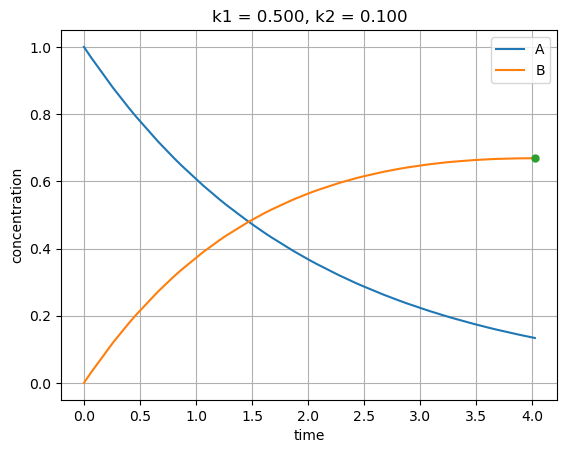

In [24]:
soln = ode_model_builder().bind(transformer('dae.collocation')).bind(solver('ipopt'))
tf, b = soln()
print(f"   tf = {tf:0.3f}")
print(f"b(tf) = {b:0.3f}")

### Alterntive syntax

Show how the workflow functions can be composed into a single operation.

(0.15767005981401438, 0.8541314382648219)

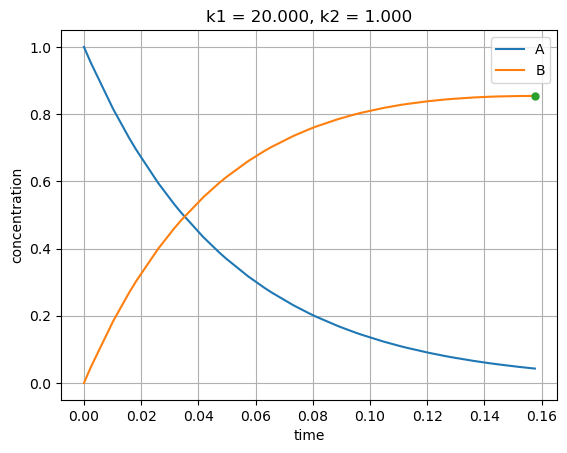

In [25]:
collocation = transformer('dae.collocation')
ipopt = solver('ipopt')

(soln := ode_model_builder(20, 1) >> collocation >> ipopt)()

### Composition

Show how a workflow can be written as a composition of functions.

(4.023594361612317, 0.6687402900841761)

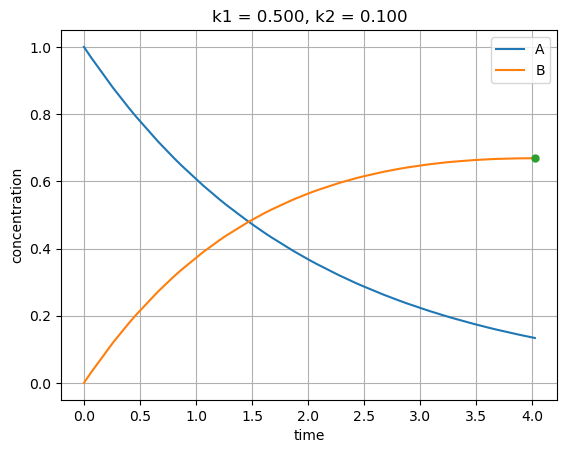

In [26]:
ode_solver = compose(collocation, ipopt)

(soln := ode_model_builder().bind(ode_solver))()

## Useful references

* Wikipedia: [Monad (functional programming)]( https://en.wikipedia.org/w/index.php?title=Monad_(functional_programming)&oldid=1143728441) 
* https://www.philliams.com/monads-in-python/
* https://www.codeproject.com/Articles/5290753/Simple-Introduction-to-Monads